In [1]:
import os
import logging


import matplotlib.pyplot as plt
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import find_repo_root
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference, train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root

In [2]:
features = list_available_features()
tensed_features = list_tensed_features()
interventions = list_interventions()
outcomes = list_outcomes()

print(features)
print(tensed_features)
print(interventions)
print(outcomes)

['ethnic_composition', 'gdp', 'industry', 'industry_accommodation_food_services_total', 'industry_admin_support_services_total', 'industry_agriculture_total', 'industry_arts_recreation_total', 'industry_construction_total', 'industry_educational_services_total', 'industry_finance_insurance_total', 'industry_healthcare_social_services_total', 'industry_information_total', 'industry_management_enterprises_total', 'industry_manufacturing_total', 'industry_mining_total', 'industry_other_services_total', 'industry_professional_services_total', 'industry_public_administration_total', 'industry_real_estate_total', 'industry_retail_trade_total', 'industry_transportation_warehousing_total', 'industry_utilities_total', 'industry_wholesale_trade_total', 'population', 'spending_HHS', 'spending_commerce', 'spending_transportation', 'transport', 'unemployment_rate', 'urbanization']
['gdp', 'industry_accommodation_food_services_total', 'industry_admin_support_services_total', 'industry_agriculture_to

In [3]:
def cities_model_interactions(
    N_t,
    N_cov,
    N_s,
    N_u,
    N_obs,
    state_index_sparse,
    state_index,
    time_index,
    unit_index,
    leeway=0.2,
):
    Y_bias = pyro.sample("Y_bias", dist.Normal(0, leeway))
    T_bias = pyro.sample("T_bias", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))

    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))

    observations_plate = pyro.plate("observations_plate", N_obs, dim=-1)

    counties_plate = pyro.plate("counties_plate", N_u, dim=-2)
    states_plate = pyro.plate("states_plate", N_s, dim=-3)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-4)
    time_plate = pyro.plate("time_plate", N_t, dim=-5)

    with covariates_plate:
        X_bias = pyro.sample("X_bias", dist.Normal(0, leeway)).squeeze()
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1)).squeeze()
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway)).squeeze()
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway)).squeeze()

    with states_plate:
        weight_UsT = pyro.sample("weight_UsT", dist.Normal(0, leeway)).squeeze()
        weight_UsY = pyro.sample("weight_UsY", dist.Normal(0, leeway)).squeeze()

        with covariates_plate:
            weight_UsX = pyro.sample("weight_UsX", dist.Normal(0, leeway)).squeeze()

    with time_plate:
        weight_UtT = pyro.sample("weight_UtT", dist.Normal(0, leeway)).squeeze()
        weight_UtY = pyro.sample("weight_UtY", dist.Normal(0, leeway)).squeeze()

    with counties_plate:
        UsX_weight_selected = weight_UsX.squeeze().T.squeeze()[state_index_sparse]
        X_means = torch.einsum("c,uc->uc", X_bias, UsX_weight_selected)
        X = pyro.sample("X", dist.Normal(X_means, sigma_X)).squeeze()

    XT_weighted = torch.einsum("uc, c -> u", X, weight_XT)
    XY_weighted = torch.einsum("uc, c -> u", X, weight_XY)

    with observations_plate:
        T_mean = (
            T_bias
            + weight_UtT[time_index]
            + weight_UsT[state_index]
            + XT_weighted[unit_index]
        )

        T = pyro.sample("T", dist.Normal(T_mean, sigma_T))

        Y_mean = (
            Y_bias
            + weight_UtY[time_index]
            + weight_UsY[state_index]
            + weight_TY * T
            + XY_weighted[unit_index]
        )

        Y = pyro.sample("Y", dist.Normal(Y_mean, sigma_Y))

    return Y

In [26]:
# this example will be generalized into a 
# general insight class
# mostly used for quality checks
# and country-level insights
# outcome_dataset='industry_transportation_warehousing_total'
# intervention_dataset='spending_transportation'
outcome_dataset='unemployment_rate'
intervention_dataset='spending_commerce'

forward_shift = 3

dg = DataGrabber()
dg.get_features_std_long([intervention_dataset, outcome_dataset])

root = find_repo_root()
log_dir = os.path.join(root, "data", "model_outputs/general_insights")
log_file_path = os.path.join(log_dir, ".general_insights.log")
os.makedirs(log_dir, exist_ok=True)

logging.basicConfig(filename=log_file_path, filemode="w", 
                format="%(asctime)s → %(name)s → %(levelname)s: %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO)

intervention_variable = dg.std_long[intervention_dataset].columns[-1]

# loaded_data = {}
# model_args = {}
# loaded_guides = {}
# predictives = {}
# samples = {}
# tau_samples = {}
# #for forward_shift in [1, 2, 3]:

loaded_data =  prep_data_for_interaction_inference(
        outcome_dataset=outcome_dataset,
intervention_dataset=intervention_dataset,
intervention_variable=intervention_variable,
forward_shift=forward_shift, 
    )

print(loaded_data.keys())

model_args = (
        loaded_data['N_t'],
        loaded_data['N_cov'],
        loaded_data['N_s'],
        loaded_data['N_u'],
        loaded_data['N_obs'],
        loaded_data['state_index_sparse'],
        loaded_data['state_index'],
        loaded_data['time_index'],
        loaded_data['unit_index'],
    )

# print("ntdata", loaded_data[forward_shift]['N_t'])

model_conditioned =  pyro.condition(
            cities_model_interactions,
            data={"T": loaded_data['intervention'], "Y": loaded_data['y'], 
                  "X": loaded_data['covariates_sparse']},
        )

dict_keys(['N_t', 'N_cov', 'N_s', 'N_u', 'N_obs', 'unit_index', 'state_index', 'time_index', 'unit_index_sparse', 'state_index_sparse', 'covariates', 'covariates_sparse', 'intervention', 'y'])


[iteration 0001] loss: 96968.9618
[iteration 0101] loss: -74009.9759
[iteration 0201] loss: -75935.5478
[iteration 0301] loss: -76198.6731
[iteration 0401] loss: -75802.0539
[iteration 0501] loss: -76235.7732
[iteration 0601] loss: -76511.6951
[iteration 0701] loss: -76302.1104
[iteration 0801] loss: -76878.9157
[iteration 0901] loss: -76909.5251


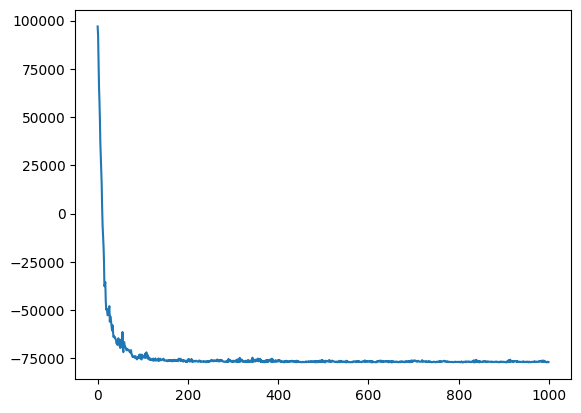

In [27]:
guide = train_interactions_model(model_conditioned, num_iterations=1000, model_args=model_args , lr=0.1, plot_loss=True)

In [28]:
predictive = Predictive(model=cities_model_interactions, guide=guide, num_samples=1000, parallel=False)
samples = predictive(*model_args)

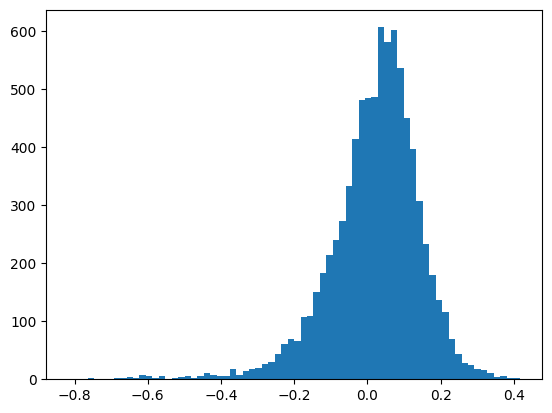

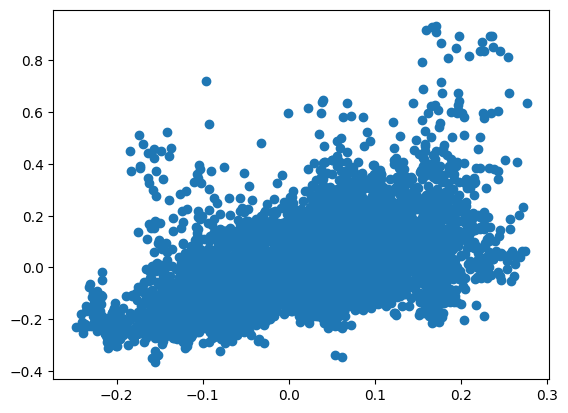

In [29]:
# plot residuals
y = loaded_data['y']
predictions = samples['Y'].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)

plt.hist(mean_predictions -y, bins=70)
plt.show()

# predictive check
plt.scatter(mean_predictions, y)

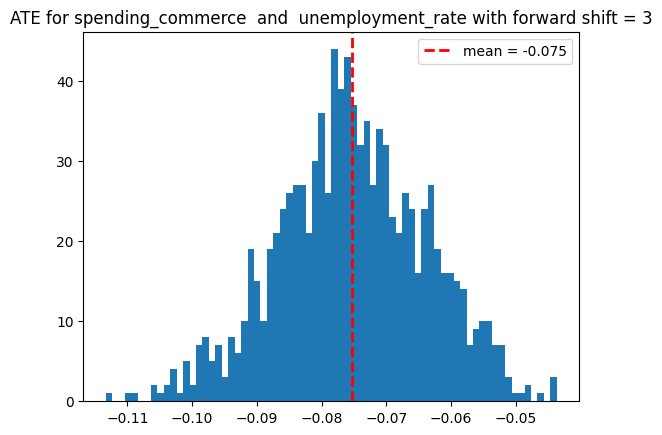

In [30]:
tau_samples = samples['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title(f"ATE for {intervention_dataset}  and  {outcome_dataset} with forward shift = {forward_shift}")
plt.legend()
plt.show()

In [31]:
guide_name = (
            f"{intervention_dataset}_{outcome_dataset}_{forward_shift}"
        )
serialized_guide = dill.dumps(guide)
file_path = os.path.join(
    root, "data/model_guides", f"{guide_name}_guide.pkl"
)
with open(file_path, "wb") as file:
    file.write(serialized_guide)

logging.info(f"Guide {guide_name} has been saved.")

In [32]:
# find and load the guides
guide_name = (f"{intervention_dataset}_{outcome_dataset}_{forward_shift}")
print(guide_name)
file_path = os.path.join(root, "data/model_guides", f"{guide_name}_guide.pkl")
print(file_path)
with open(file_path, "rb") as file:
    guide_loaded  = dill.load(file)

# print("predictive")

predictive_loaded = Predictive(cities_model_interactions, guide=guide_loaded, num_samples=1000, parallel=False)

print("sampling")
samples_loaded = predictive_loaded(*model_args)

spending_commerce_unemployment_rate_3
/home/rafal/s78projects/cities/data/model_guides/spending_commerce_unemployment_rate_3_guide.pkl
sampling


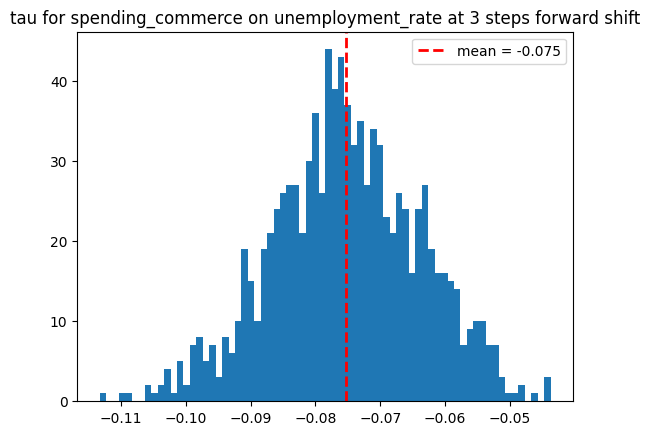

In [33]:
tau_samples_loaded = samples_loaded['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title(f"tau for {intervention_dataset} on {outcome_dataset} at {forward_shift} steps forward shift")
plt.legend()
plt.show()

In [2]:
unemployment_commerce_2 = InteractionsModel(outcome_dataset='unemployment_rate',
    intervention_dataset='spending_commerce',
    intervention_variable='total_obligated_amount',
    forward_shift = 2,
    num_iterations= 2500)

['N_cov', 'N_obs', 'N_s', 'N_t', 'N_u', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'covariates', 'covariates_sparse', 'forward_shift', 'intervention', 'intervention_dataset', 'intervention_variable', 'model', 'model_args', 'model_conditioned', 'model_rendering', 'num_iterations', 'outcome_dataset', 'plot_loss', 'root', 'save_guide', 'state_index', 'state_index_sparse', 'time_index', 'train_interactions_model', 'unit_index', 'unit_index_sparse', 'y']


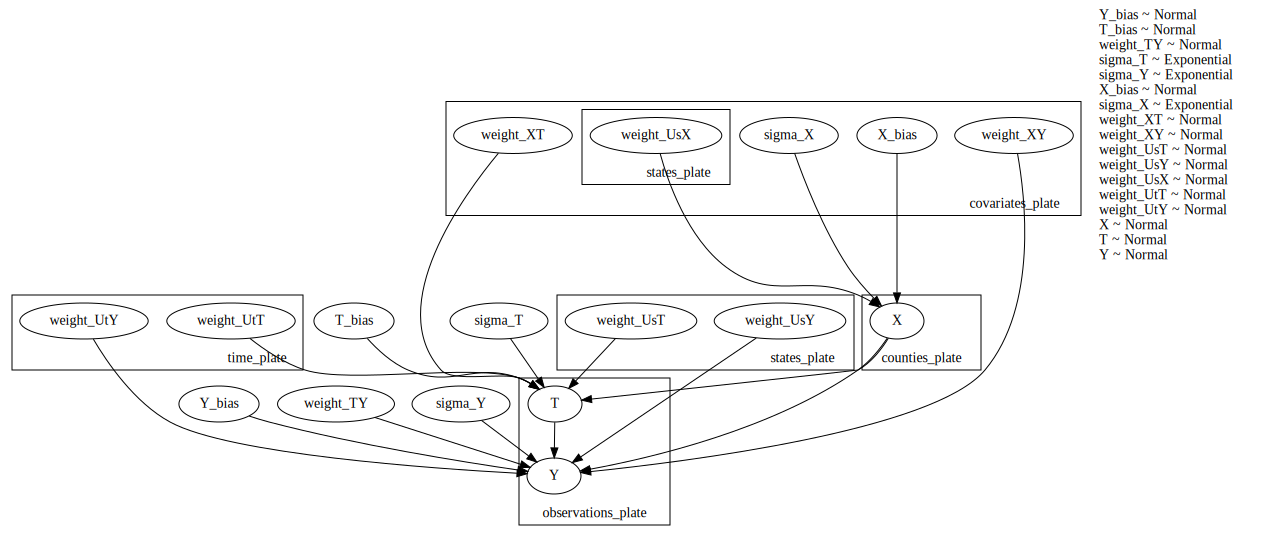

In [3]:
print(dir(unemployment_commerce_2))
display(unemployment_commerce_2.model_rendering)

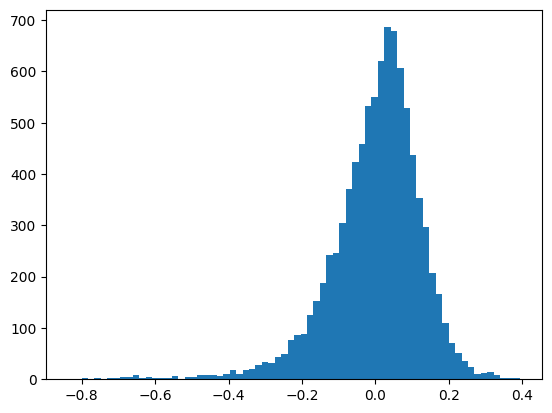

In [11]:
# plot residuals
y = loaded_data['y']
predictions = samples['Y'].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)

plt.hist(mean_predictions -y, bins=70)
plt.show()

In [12]:
observed_mean = torch.mean(y)
tss = torch.sum((y - observed_mean) ** 2)
print("tss", tss)
rss = torch.sum((y - mean_predictions) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

tss tensor(206.3684)
rss tensor(144.1228)
r_squared tensor(0.3016)
